In [46]:
## colab이 아닌곳에서 돌릴시에는 추가 설치필요
# !pip install yfinance
# !pip install numpy
# !pip install matplotlib
# !pip install pandas
# !pip install plotly

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


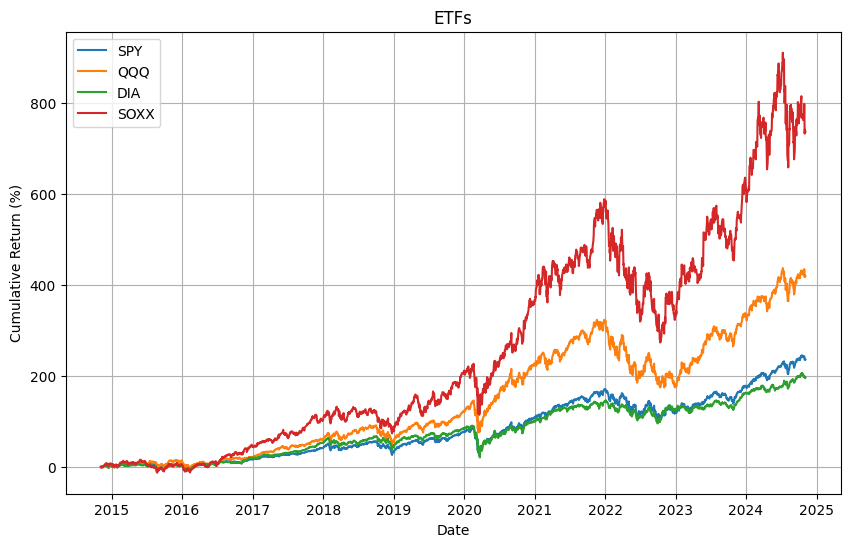

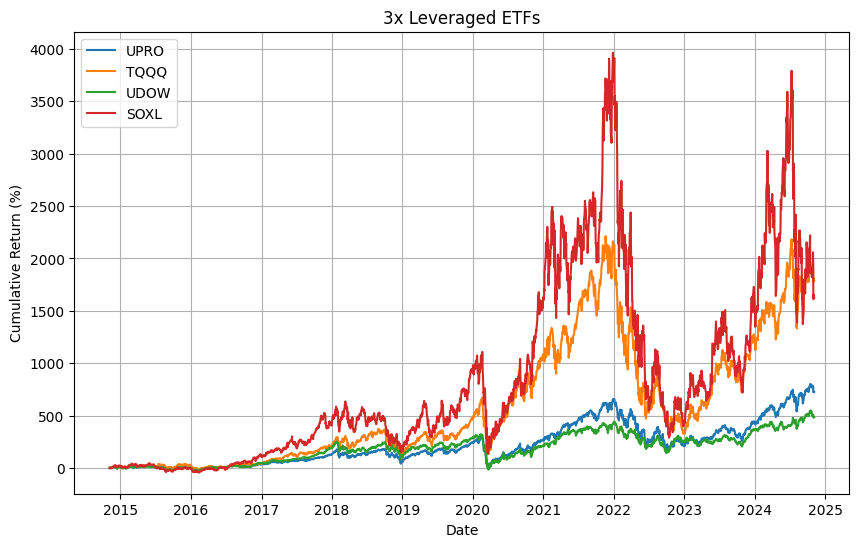

In [47]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 찾고자 하는 etf를 리스트에 넣기
general_etfs = ["SPY", "QQQ", "DIA", "SOXX"]
leveraged_etfs = ["UPRO", "TQQQ", "UDOW", "SOXL"]
start_date = "2014-11-05"
end_date = "2024-11-05"

# yfinance 를 이용해서 데이터 추출 및 csv파일을 만드는 함수(데이터 이미 존재시 생략가능)
def fetch_etf_data(tickers):
    data = {}
    for ticker in tickers:
        df = yf.download(ticker, start=start_date, end=end_date)
        df['pct_change'] = df['Adj Close'].pct_change() * 100  # Daily percentage change
        df['drawdown'] = (df['Adj Close'] / df['Adj Close'].cummax() - 1) * 100  # Drawdown
        df['cumulative_return'] = (df['Adj Close'] / df['Adj Close'].iloc[0] - 1) * 100  # Cumulative return
        data[ticker] = df.dropna()
    return data

# 2014부터 현재까지의 주식 상승률을 보여주는 함수(matplotlib이용)
def uppercentage(data, title):
    plt.figure(figsize=(10, 6))
    for ticker, df in data.items():
        plt.plot(df.index, df['cumulative_return'], label=ticker)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return (%)")
    plt.legend()
    plt.grid()
    plt.show()


general_data = fetch_etf_data(general_etfs)
leveraged_data = fetch_etf_data(leveraged_etfs)
uppercentage(general_data, "ETFs")
uppercentage(leveraged_data, "3x Leveraged ETFs")

In [48]:
## 데이터셋 만들기

# 개별 종목 분석시작
tickers = ["QQQ", "TQQQ"]
start_date = "2014-01-01"
end_date = "2024-11-05"

# download
data = {ticker: yf.download(ticker, start=start_date, end=end_date) for ticker in tickers}

# Save data as a CSV file
for ticker, df in data.items():
    filename = f"{ticker}_data.csv"
    df.to_csv(filename)
    print(f"{filename} saved.")

########파일이 기존에 있다면..
qqq_data = pd.read_csv("QQQ_data.csv", index_col=0, parse_dates=True)
tqqq_data = pd.read_csv("TQQQ_data.csv", index_col=0, parse_dates=True)


# Pandas file을 numeric으로 바꿔줘야한다.
qqq_data['Adj Close'] = pd.to_numeric(qqq_data['Adj Close'], errors='coerce')
qqq_data = qqq_data.dropna(subset=['Adj Close'])

tqqq_data['Adj Close'] = pd.to_numeric(tqqq_data['Adj Close'], errors='coerce')
tqqq_data = tqqq_data.dropna(subset=['Adj Close'])
tqqq_data = tqqq_data.sort_index()



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

QQQ_data.csv saved.
TQQQ_data.csv saved.



/var/folders/ch/xd8qv8dj7mndh_r4w2kdw_040000gn/T/ipykernel_47541/1127447396.py:18: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/var/folders/ch/xd8qv8dj7mndh_r4w2kdw_040000gn/T/ipykernel_47541/1127447396.py:19: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [49]:
#5일 연속 상승 하는 기간을 찾기 위한 함수
def find_consecutive_rises(data, min_days=5):
    # Create a column to track daily increases (True for increase, False otherwise)
    data['rise'] = data['Adj Close'].diff() > 0

    # Identify consecutive rising periods
    data['group'] = (data['rise'] != data['rise'].shift()).cumsum()
    rising_groups = data[data['rise']].groupby('group')

    # Filter groups with at least `min_days` consecutive rises
    rising_periods = rising_groups.filter(lambda x: len(x) >= min_days)

    # Calculate start, end, and returns for each rising period
    result = (
        rising_periods.groupby('group')
        .agg(
            start_date=('Adj Close', lambda x: x.index[0]),
            end_date=('Adj Close', lambda x: x.index[-1]),
            start_price=('Adj Close', 'first'),
            end_price=('Adj Close', 'last')
        )
        .assign(return_pct=lambda x: ((x['end_price'] / x['start_price']) - 1) * 100)
    )
    return result

#각 데이터에 함수 실행
qqq_rising_periods = find_consecutive_rises(qqq_data.copy())
tqqq_rising_periods = find_consecutive_rises(tqqq_data.copy())

# Combine results for comparison
comparison_df = pd.merge(
    qqq_rising_periods[['start_date', 'end_date', 'return_pct']],
    tqqq_rising_periods[['start_date', 'end_date', 'return_pct']],
    left_on=['start_date', 'end_date'],
    right_on=['start_date', 'end_date'],
    suffixes=('_QQQ', '_TQQQ'),
    how='inner'
)

In [50]:
print(comparison_df)

# 데이터 저장
comparison_df.to_csv("QQQ_vs_TQQQ_Rising_Period_Comparison.csv", index=False)
print("Comparison saved to 'QQQ_vs_TQQQ_Rising_Period_Comparison.csv'")


                   start_date                   end_date  return_pct_QQQ  \
0   2014-02-06 00:00:00+00:00  2014-02-18 00:00:00+00:00        5.223310   
1   2014-04-14 00:00:00+00:00  2014-04-22 00:00:00+00:00        3.255877   
2   2014-06-25 00:00:00+00:00  2014-07-03 00:00:00+00:00        2.583330   
3   2014-08-13 00:00:00+00:00  2014-08-19 00:00:00+00:00        2.354035   
4   2014-08-21 00:00:00+00:00  2014-08-27 00:00:00+00:00        0.626876   
..                        ...                        ...             ...   
63  2024-05-09 00:00:00+00:00  2024-05-15 00:00:00+00:00        2.693758   
64  2024-06-10 00:00:00+00:00  2024-06-18 00:00:00+00:00        4.384396   
65  2024-07-01 00:00:00+00:00  2024-07-10 00:00:00+00:00        4.365868   
66  2024-08-08 00:00:00+00:00  2024-08-19 00:00:00+00:00        7.409550   
67  2024-09-09 00:00:00+00:00  2024-09-13 00:00:00+00:00        4.594466   

    return_pct_TQQQ  
0         16.429440  
1          9.981856  
2          7.885391  

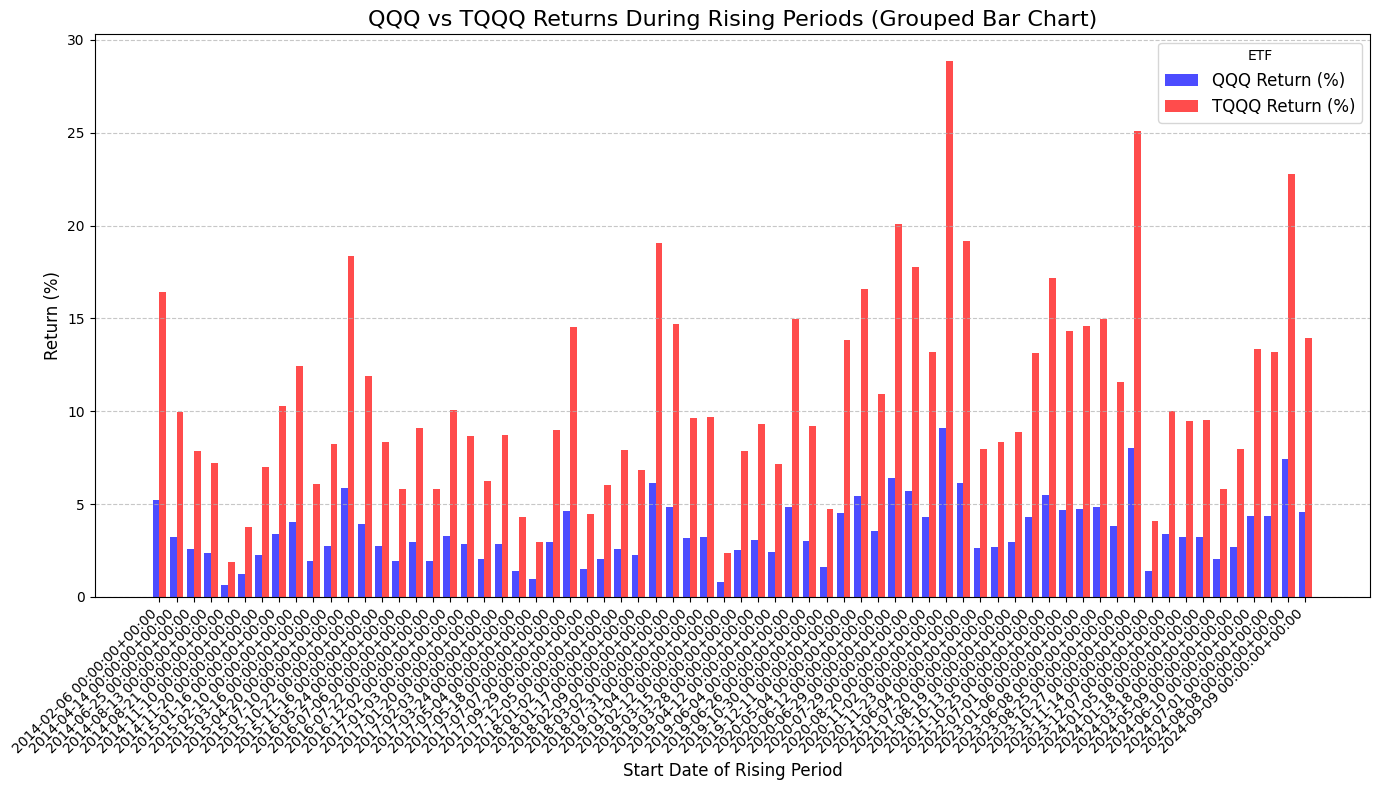

In [51]:
#그래프 그리기

#X축설정
x = np.arange(len(comparison_df['start_date']))
width = 0.4  # Width of the bars

#그래프 크기 설정
plt.figure(figsize=(14, 8))

# QQQ
plt.bar(
    x - width / 2,
    comparison_df['return_pct_QQQ'],
    width,
    label='QQQ Return (%)',
    color='blue',
    alpha=0.7
)

# TQQQ
plt.bar(
    x + width / 2,
    comparison_df['return_pct_TQQQ'],
    width,
    label='TQQQ Return (%)',
    color='red',
    alpha=0.7
)

#그래프 그리기
plt.title('QQQ vs TQQQ Returns During Rising Periods (Grouped Bar Chart)', fontsize=16)
plt.xlabel('Start Date of Rising Period', fontsize=12)
plt.ylabel('Return (%)', fontsize=12)
plt.xticks(x, comparison_df['start_date'], rotation=45, ha='right')
plt.legend(title='ETF', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



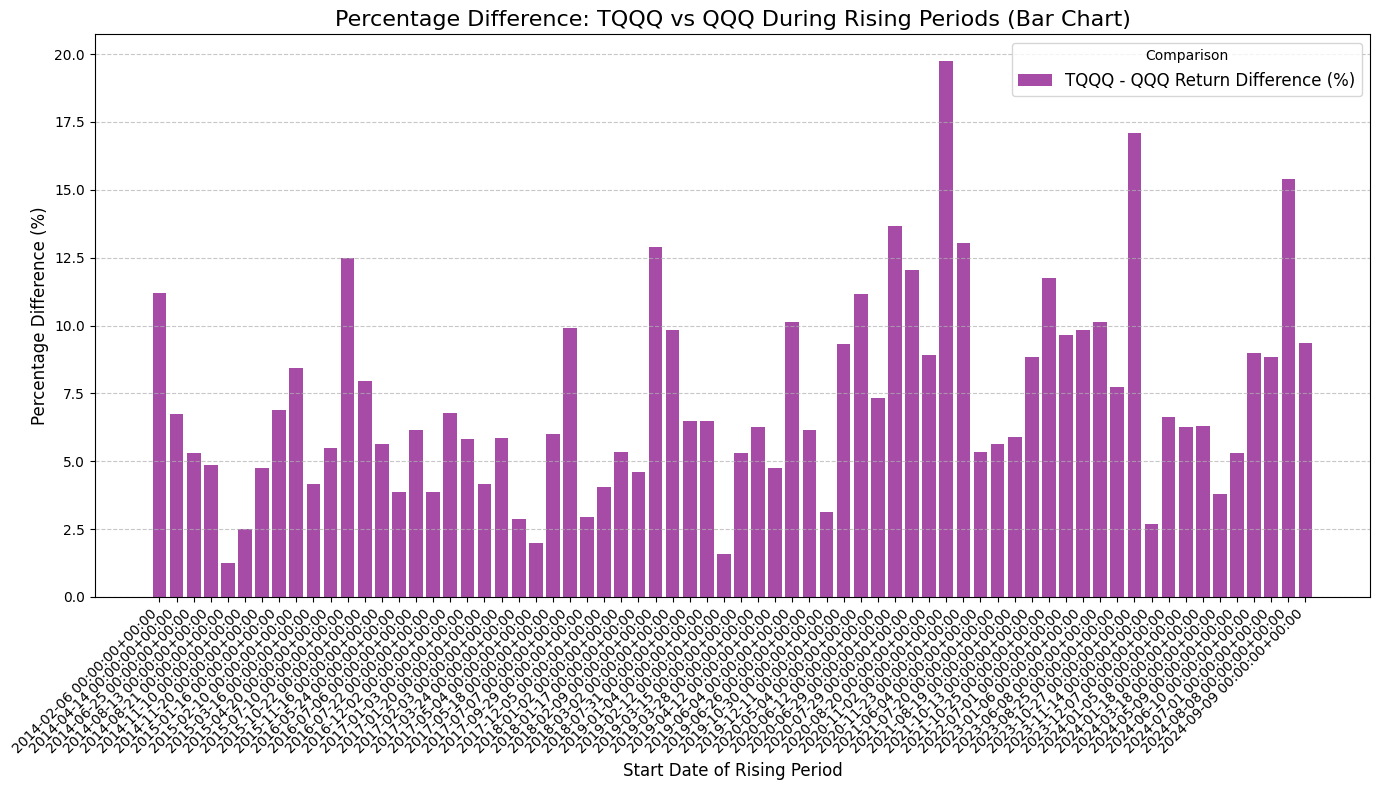

                   start_date                   end_date  return_pct_QQQ  \
0   2014-02-06 00:00:00+00:00  2014-02-18 00:00:00+00:00        5.223310   
1   2014-04-14 00:00:00+00:00  2014-04-22 00:00:00+00:00        3.255877   
2   2014-06-25 00:00:00+00:00  2014-07-03 00:00:00+00:00        2.583330   
3   2014-08-13 00:00:00+00:00  2014-08-19 00:00:00+00:00        2.354035   
4   2014-08-21 00:00:00+00:00  2014-08-27 00:00:00+00:00        0.626876   
..                        ...                        ...             ...   
63  2024-05-09 00:00:00+00:00  2024-05-15 00:00:00+00:00        2.693758   
64  2024-06-10 00:00:00+00:00  2024-06-18 00:00:00+00:00        4.384396   
65  2024-07-01 00:00:00+00:00  2024-07-10 00:00:00+00:00        4.365868   
66  2024-08-08 00:00:00+00:00  2024-08-19 00:00:00+00:00        7.409550   
67  2024-09-09 00:00:00+00:00  2024-09-13 00:00:00+00:00        4.594466   

    return_pct_TQQQ  Percentage Difference (%)  
0         16.429440                  1

In [52]:
#두번째 그래프 그리기

# 두 티커 %의 차이 계산하기
comparison_df['Percentage Difference (%)'] = (
    comparison_df['return_pct_TQQQ'] - comparison_df['return_pct_QQQ']
)

#그래프 크기 설정
plt.figure(figsize=(14, 8))

# Plot bar chart
plt.bar(
    comparison_df['start_date'],
    comparison_df['Percentage Difference (%)'],
    color='purple',
    alpha=0.7,
    label='TQQQ - QQQ Return Difference (%)'
)

#그래프 그리기
plt.title('Percentage Difference: TQQQ vs QQQ During Rising Periods (Bar Chart)', fontsize=16)
plt.xlabel('Start Date of Rising Period', fontsize=12)
plt.ylabel('Percentage Difference (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Comparison', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(comparison_df[['start_date', 'end_date', 'return_pct_QQQ', 'return_pct_TQQQ', 'Percentage Difference (%)']])


In [53]:
#5일 연속 하락 하는 기간을 찾기 위한 함수
def find_consecutive_drops(data, min_days=5):
    # Create a column to track daily decreases (True for decrease, False otherwise)
    data['drop'] = data['Adj Close'].diff() < 0

    # Identify consecutive dropping periods
    data['group'] = (data['drop'] != data['drop'].shift()).cumsum()
    dropping_groups = data[data['drop']].groupby('group')

    # Filter groups with at least `min_days` consecutive drops
    dropping_periods = dropping_groups.filter(lambda x: len(x) >= min_days)

    # Calculate start, end, and returns for each dropping period
    result = (
        dropping_periods.groupby('group')
        .agg(
            start_date=('Adj Close', lambda x: x.index[0]),
            end_date=('Adj Close', lambda x: x.index[-1]),
            start_price=('Adj Close', 'first'),
            end_price=('Adj Close', 'last')
        )
        .assign(return_pct=lambda x: ((x['end_price'] / x['start_price']) - 1) * 100)
    )
    return result

#각 데이터에 함수 실행
qqq_dropping_periods = find_consecutive_drops(qqq_data.copy())
tqqq_dropping_periods = find_consecutive_drops(tqqq_data.copy())

# Combine results for comparison
comparison_drops_df = pd.merge(
    qqq_dropping_periods[['start_date', 'end_date', 'return_pct']],
    tqqq_dropping_periods[['start_date', 'end_date', 'return_pct']],
    left_on=['start_date', 'end_date'],
    right_on=['start_date', 'end_date'],
    suffixes=('_QQQ', '_TQQQ'),
    how='inner'
)





In [54]:
print(comparison_drops_df)

# 데이터 저장
comparison_drops_df.to_csv("QQQ_vs_TQQQ_Dropping_Period_Comparison.csv", index=False)
print("Comparison saved to 'QQQ_vs_TQQQ_Dropping_Period_Comparison.csv'")

                   start_date                   end_date  return_pct_QQQ  \
0   2014-01-23 00:00:00+00:00  2014-01-29 00:00:00+00:00       -4.012217   
1   2015-01-09 00:00:00+00:00  2015-01-15 00:00:00+00:00       -2.894180   
2   2015-07-21 00:00:00+00:00  2015-07-27 00:00:00+00:00       -3.274533   
3   2015-08-18 00:00:00+00:00  2015-08-25 00:00:00+00:00      -11.519017   
4   2015-11-09 00:00:00+00:00  2015-11-13 00:00:00+00:00       -3.284318   
5   2015-12-30 00:00:00+00:00  2016-01-08 00:00:00+00:00       -8.175132   
6   2016-02-02 00:00:00+00:00  2016-02-09 00:00:00+00:00       -5.707267   
7   2016-10-25 00:00:00+00:00  2016-11-04 00:00:00+00:00       -4.648067   
8   2018-03-13 00:00:00+00:00  2018-03-19 00:00:00+00:00       -2.526874   
9   2019-05-22 00:00:00+00:00  2019-05-29 00:00:00+00:00       -2.756609   
10  2019-07-29 00:00:00+00:00  2019-08-05 00:00:00+00:00       -7.136965   
11  2021-02-16 00:00:00+00:00  2021-02-23 00:00:00+00:00       -4.190270   
12  2021-09-

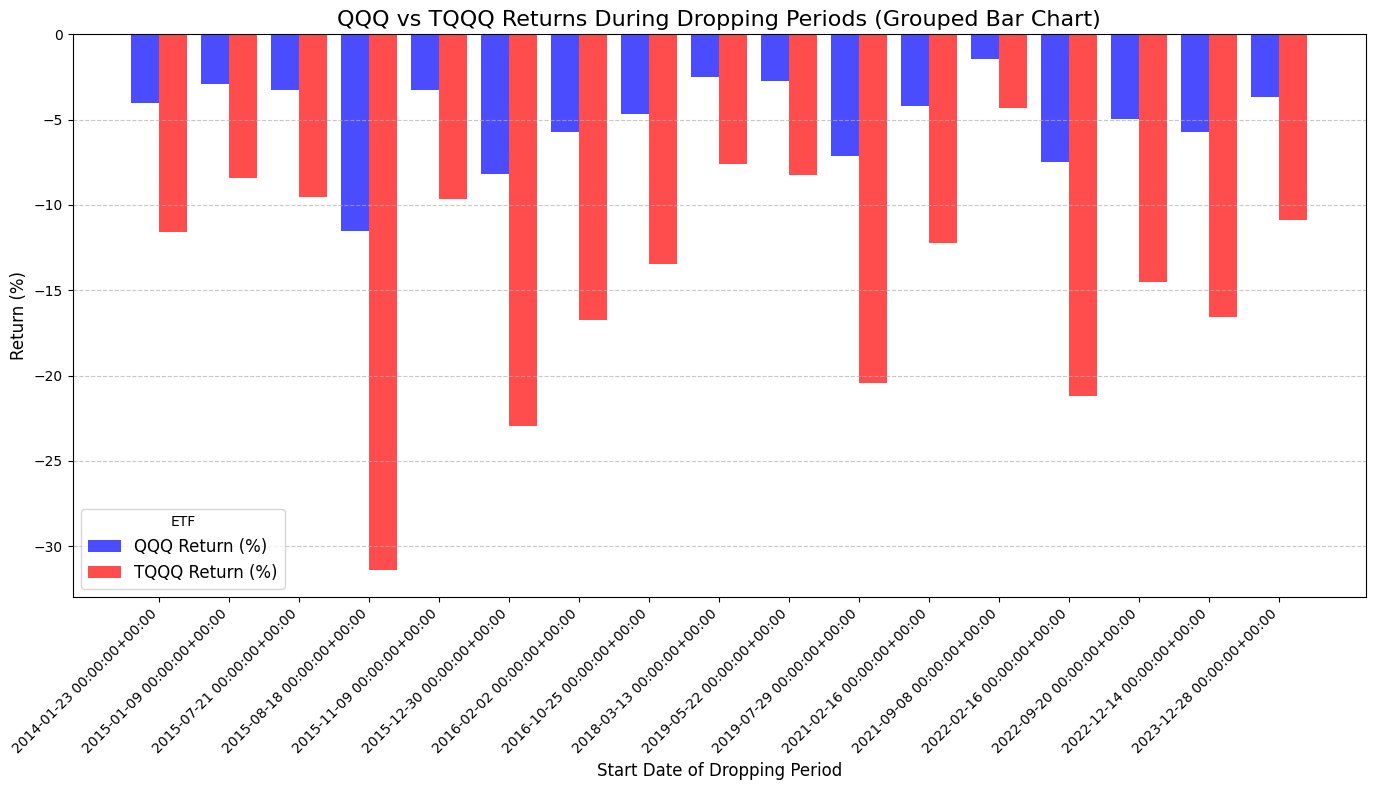

In [55]:
# 그래프 설정
plt.figure(figsize=(14, 8))

# QQQ
plt.bar(
    np.arange(len(comparison_drops_df['start_date'])) - width / 2,
    comparison_drops_df['return_pct_QQQ'],
    width,
    label='QQQ Return (%)',
    color='blue',
    alpha=0.7
)

# TQQQ
plt.bar(
    np.arange(len(comparison_drops_df['start_date'])) + width / 2,
    comparison_drops_df['return_pct_TQQQ'],
    width,
    label='TQQQ Return (%)',
    color='red',
    alpha=0.7
)

# 그래프 그리기
plt.title('QQQ vs TQQQ Returns During Dropping Periods (Grouped Bar Chart)', fontsize=16)
plt.xlabel('Start Date of Dropping Period', fontsize=12)
plt.ylabel('Return (%)', fontsize=12)
plt.xticks(np.arange(len(comparison_drops_df['start_date'])), comparison_drops_df['start_date'], rotation=45, ha='right')
plt.legend(title='ETF', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


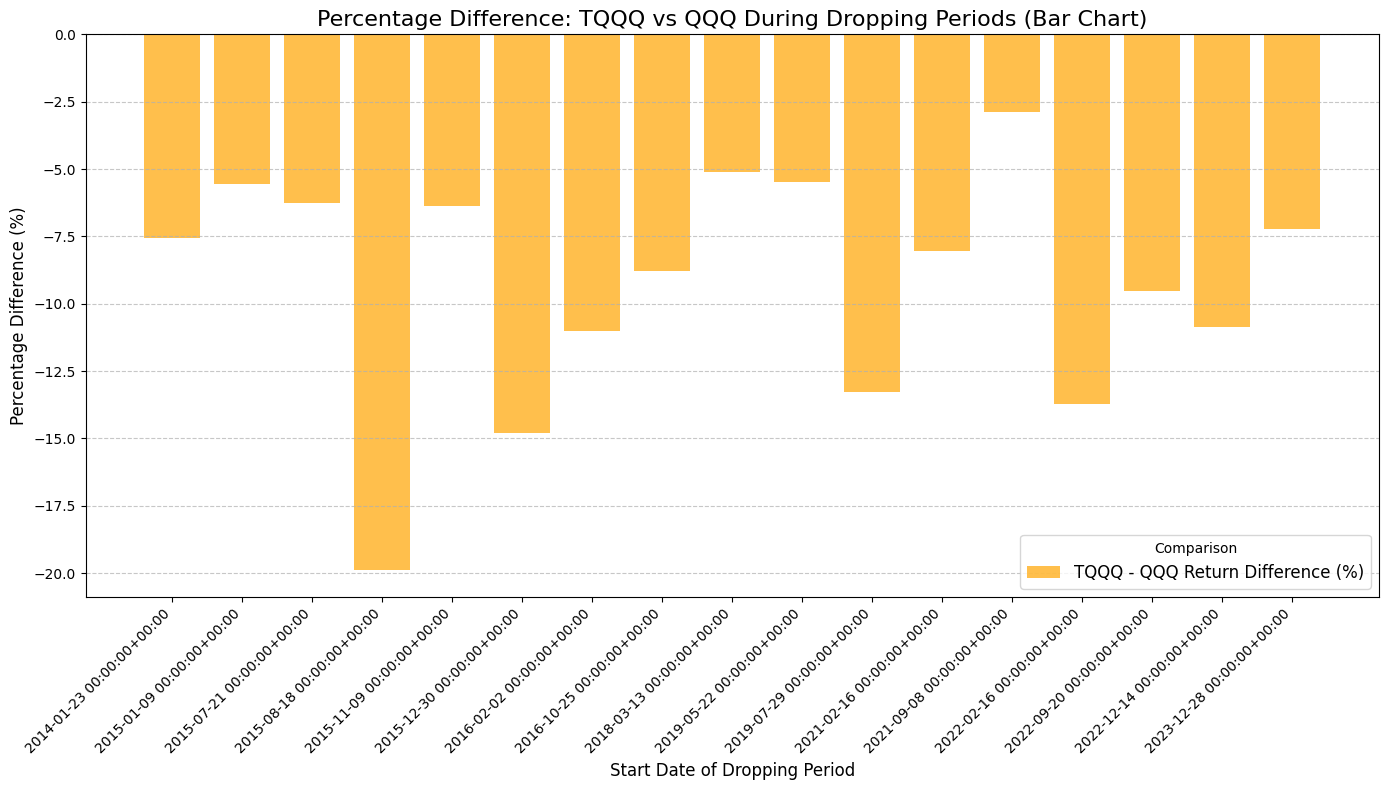

                   start_date                   end_date  return_pct_QQQ  \
0   2014-01-23 00:00:00+00:00  2014-01-29 00:00:00+00:00       -4.012217   
1   2015-01-09 00:00:00+00:00  2015-01-15 00:00:00+00:00       -2.894180   
2   2015-07-21 00:00:00+00:00  2015-07-27 00:00:00+00:00       -3.274533   
3   2015-08-18 00:00:00+00:00  2015-08-25 00:00:00+00:00      -11.519017   
4   2015-11-09 00:00:00+00:00  2015-11-13 00:00:00+00:00       -3.284318   
5   2015-12-30 00:00:00+00:00  2016-01-08 00:00:00+00:00       -8.175132   
6   2016-02-02 00:00:00+00:00  2016-02-09 00:00:00+00:00       -5.707267   
7   2016-10-25 00:00:00+00:00  2016-11-04 00:00:00+00:00       -4.648067   
8   2018-03-13 00:00:00+00:00  2018-03-19 00:00:00+00:00       -2.526874   
9   2019-05-22 00:00:00+00:00  2019-05-29 00:00:00+00:00       -2.756609   
10  2019-07-29 00:00:00+00:00  2019-08-05 00:00:00+00:00       -7.136965   
11  2021-02-16 00:00:00+00:00  2021-02-23 00:00:00+00:00       -4.190270   
12  2021-09-

In [56]:
#두번째 그래프 그리기

# 두 티커 %의 차이 계산하기
comparison_drops_df['Percentage Difference (%)'] = (
    comparison_drops_df['return_pct_TQQQ'] - comparison_drops_df['return_pct_QQQ']
)

# 그래프 크기
plt.figure(figsize=(14, 8))

# 그래프  설정
plt.bar(
    comparison_drops_df['start_date'],
    comparison_drops_df['Percentage Difference (%)'],
    color='orange',
    alpha=0.7,
    label='TQQQ - QQQ Return Difference (%)'
)

# 그래프 그리기
plt.title('Percentage Difference: TQQQ vs QQQ During Dropping Periods (Bar Chart)', fontsize=16)
plt.xlabel('Start Date of Dropping Period', fontsize=12)
plt.ylabel('Percentage Difference (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Comparison', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(comparison_drops_df[['start_date', 'end_date', 'return_pct_QQQ', 'return_pct_TQQQ', 'Percentage Difference (%)']])



In [57]:
# Volatiliy decay에 대해서 보여주기
attempts = 3  # 최대횟수
benchmark_value = None

for attempt in range(attempts):
    try:
        user_input = input("Enter the benchmark value for QQQ (100에서 500 사이 숫자값만): ")
        benchmark_value = float(user_input)
        if 100 <= benchmark_value <= 500:
            break  # Exit loop if input is valid
        else:
            print("Invalid input! Please enter a number between 100 and 500.")
    except ValueError:
        print("Invalid input! Please enter a numeric value.")

    if attempt < attempts - 1:
        print(f"Attempts remaining: {attempts - attempt - 1}")
    else:
        print("Too many invalid attempts. Using default benchmark value: 400")
        benchmark_value = 400

# Calculate benchmark_diff
qqq_data['benchmark_diff'] = abs(qqq_data['Adj Close'] - benchmark_value)


print(f"Benchmark value set to: {benchmark_value}")



Invalid input! Please enter a number between 100 and 500.
Attempts remaining: 2
Invalid input! Please enter a numeric value.
Attempts remaining: 1
Benchmark value set to: 375.0


                        Date  QQQ Price  TQQQ Price
0  2023-09-05 00:00:00+00:00      375.0   41.621529
1  2023-08-31 00:00:00+00:00      375.0   41.660793
2  2023-11-13 00:00:00+00:00      375.0   39.797939
3  2023-09-01 00:00:00+00:00      375.0   41.513546
4  2023-07-26 00:00:00+00:00      375.0   42.475555
5  2021-12-03 00:00:00+00:00      375.0   72.627472
6  2023-07-25 00:00:00+00:00      375.0   42.917294
7  2021-09-07 00:00:00+00:00      375.0   73.590485
8  2023-11-10 00:00:00+00:00      375.0   40.162426
9  2023-09-14 00:00:00+00:00      375.0   41.130707


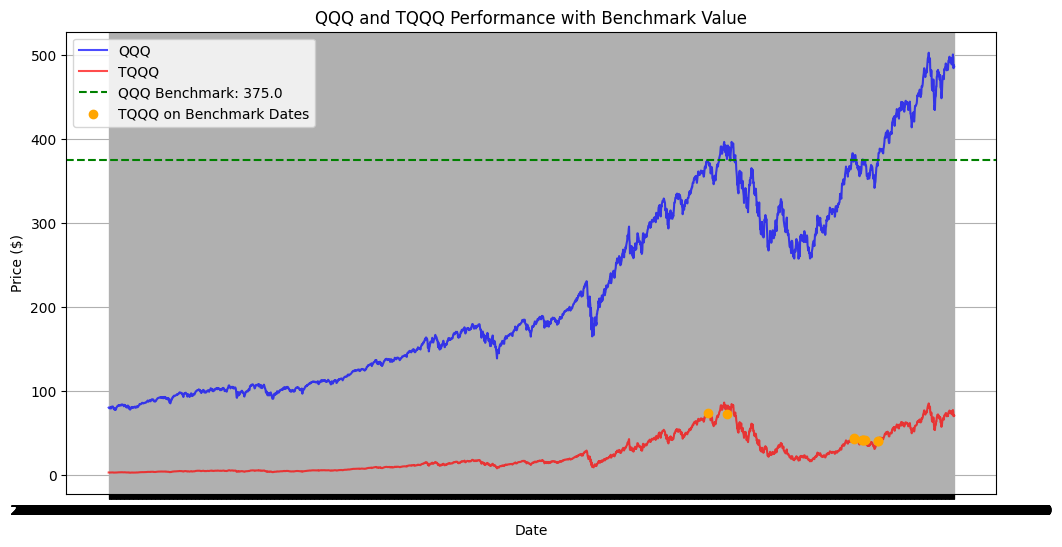

In [58]:
# 기준값 날짜의 TQQQ 데이터 추출
benchmark_dates = qqq_data.nsmallest(10, 'benchmark_diff')  # QQQ 기준값에서 가장 가까운 10개 날짜
tqqq_values_on_benchmark_dates = tqqq_data.loc[benchmark_dates.index, 'Adj Close']

# 결과를 데이터프레임으로 정리
comparison_df = pd.DataFrame({
    "Date": benchmark_dates.index,
    "QQQ Price": [benchmark_value] * len(benchmark_dates),
    "TQQQ Price": tqqq_values_on_benchmark_dates.values
}).dropna()

# 결과 출력
print(comparison_df)

# 시각화
plt.figure(figsize=(12, 6))

# QQQ와 TQQQ의 전체 추이
plt.plot(qqq_data['Adj Close'], label='QQQ', color='blue', alpha=0.7)
plt.plot(tqqq_data['Adj Close'], label='TQQQ', color='red', alpha=0.7)

# QQQ 기준값 강조
plt.axhline(benchmark_value, color='green', linestyle='--', label=f'QQQ Benchmark: {benchmark_value}')

# 기준값 날짜의 TQQQ 데이터 강조
plt.scatter(comparison_df['Date'], comparison_df['TQQQ Price'], color='orange', label='TQQQ on Benchmark Dates', zorder=5)

# 그래프 설정
plt.title("QQQ and TQQQ Performance with Benchmark Value")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid()
plt.show()


In [59]:
import plotly.graph_objects as go

# 그래프 plotly로 그리기
fig = go.Figure()

# QQQ
fig.add_trace(go.Scatter(
    x=qqq_data.index,
    y=qqq_data['Adj Close'],
    mode='lines',
    name='QQQ',
    line=dict(color='blue')
))

# TQQQ
fig.add_trace(go.Scatter(
    x=tqqq_data.index,
    y=tqqq_data['Adj Close'],
    mode='lines',
    name='TQQQ',
    line=dict(color='red')
))

# 설정값 그래프(가로선)QQQ 접점
fig.add_trace(go.Scatter(
    x=qqq_data.index,
    y=[benchmark_value] * len(qqq_data.index),
    mode='lines',
    name=f'QQQ Benchmark: {benchmark_value}',
    line=dict(color='green', dash='dash')
))

# 설정값 그래프(가로선) TQQQ 접점
fig.add_trace(go.Scatter(
    x=comparison_df['Date'],
    y=comparison_df['TQQQ Price'],
    mode='markers',
    name='TQQQ on Benchmark Dates',
    marker=dict(color='orange', size=10)
))

# 그래프 그리기
fig.update_layout(
    title="QQQ and TQQQ Performance with Benchmark Value (Interactive)",
    xaxis_title="Date",
    yaxis_title="Price ($)",
    legend_title="Legend",
    template="plotly_dark"
)
fig.show()
